In [1]:
from environments import ZeroDCleanupEnv
from agents import QAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-22 00:33:53,791	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False

In [5]:
num_episodes = 200
verbose_episode = num_episodes - 1
max_steps_per_episode = 1000
state_dim = 3
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
lr = 0.01
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.9999
epsilon_min = 0.05
batch_size = 128

In [8]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = QAgent(device=device,
                        num_action_outputs=num_agents,
                        action_size=action_dim,
                        state_dim=state_dim,
                        lr=lr,
                        gamma=gamma,
                        epsilon=epsilon,
                        epsilon_decay=epsilon_decay,
                        epsilon_min=epsilon_min,
                        batch_size=batch_size,
                        q_layers=[
                            (state_dim, 64),
                            (64, 32),
                            #(64, 64),
                            (32, 32),
                            (32, action_dim * num_agents)
                        ],
                        verbose=False)

In [9]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [10]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [11]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    state = np.array([num_apples / num_dirt, num_picker, num_cleaner])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(state, actions_list, reward, next_state)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending reward: {ending_reward}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_ep_rewards.append(ending_reward)

    if ending_reward > 5000 and ending_ep_rewards[-2] > 5000 and agentCoordinator.epsilon < 0.1:
        break

    

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


 15%|█▍        | 148/1000 [00:00<00:00, 1461.73it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 611.76it/s] 


ending reward: 2625
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 524.38it/s]


ending reward: 2624
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 426.57it/s]


ending reward: 2626
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 526.55it/s]


ending reward: 2751
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 584.80it/s]


ending reward: 2698
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 788.50it/s]


ending reward: 2670
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 759.92it/s]


ending reward: 2637
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 783.79it/s]


ending reward: 2635
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 771.64it/s]


ending reward: 2684
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 756.50it/s]


ending reward: 2733
========= End of Episode 9 =========
========= Episode 10 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 636.26it/s]


ending reward: 2714
========= End of Episode 10 =========
========= Episode 11 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 751.24it/s]


ending reward: 2663
========= End of Episode 11 =========
========= Episode 12 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 765.33it/s]


ending reward: 2614
========= End of Episode 12 =========
========= Episode 13 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 796.19it/s]


ending reward: 2754
========= End of Episode 13 =========
========= Episode 14 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 797.86it/s]


ending reward: 2658
========= End of Episode 14 =========
========= Episode 15 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 706.91it/s]


ending reward: 2728
========= End of Episode 15 =========
========= Episode 16 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 600.88it/s]


ending reward: 2694
========= End of Episode 16 =========
========= Episode 17 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 355.81it/s]


ending reward: 2757
========= End of Episode 17 =========
========= Episode 18 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 634.32it/s]


ending reward: 2687
========= End of Episode 18 =========
========= Episode 19 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 743.97it/s]


ending reward: 2695
========= End of Episode 19 =========
========= Episode 20 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 668.58it/s]


ending reward: 2630
========= End of Episode 20 =========
========= Episode 21 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 617.48it/s]


ending reward: 2763
========= End of Episode 21 =========
========= Episode 22 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 639.78it/s]


ending reward: 2712
========= End of Episode 22 =========
========= Episode 23 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 525.95it/s]


ending reward: 2662
========= End of Episode 23 =========
========= Episode 24 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 562.71it/s]


ending reward: 2744
========= End of Episode 24 =========
========= Episode 25 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 563.45it/s]


ending reward: 2754
========= End of Episode 25 =========
========= Episode 26 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 608.48it/s]


ending reward: 2668
========= End of Episode 26 =========
========= Episode 27 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 578.49it/s]


ending reward: 2600
========= End of Episode 27 =========
========= Episode 28 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 625.32it/s]


ending reward: 2834
========= End of Episode 28 =========
========= Episode 29 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 545.28it/s]


ending reward: 2688
========= End of Episode 29 =========
========= Episode 30 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 469.10it/s]


ending reward: 2614
========= End of Episode 30 =========
========= Episode 31 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 615.32it/s]


ending reward: 2706
========= End of Episode 31 =========
========= Episode 32 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 597.83it/s]


ending reward: 2829
========= End of Episode 32 =========
========= Episode 33 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 542.58it/s]


ending reward: 2552
========= End of Episode 33 =========
========= Episode 34 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 364.69it/s]


ending reward: 2682
========= End of Episode 34 =========
========= Episode 35 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 675.63it/s]


ending reward: 2723
========= End of Episode 35 =========
========= Episode 36 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 752.03it/s]


ending reward: 2711
========= End of Episode 36 =========
========= Episode 37 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 762.93it/s]


ending reward: 2782
========= End of Episode 37 =========
========= Episode 38 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 619.57it/s]


ending reward: 2578
========= End of Episode 38 =========
========= Episode 39 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 777.41it/s]


ending reward: 2666
========= End of Episode 39 =========
========= Episode 40 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 545.31it/s]


ending reward: 2789
========= End of Episode 40 =========
========= Episode 41 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 604.84it/s]


ending reward: 2597
========= End of Episode 41 =========
========= Episode 42 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 714.38it/s]


ending reward: 2712
========= End of Episode 42 =========
========= Episode 43 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 526.93it/s]


ending reward: 2787
========= End of Episode 43 =========
========= Episode 44 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 483.82it/s]


ending reward: 1922
========= End of Episode 44 =========
========= Episode 45 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 498.11it/s]


ending reward: 2830
========= End of Episode 45 =========
========= Episode 46 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 538.10it/s]


ending reward: 2266
========= End of Episode 46 =========
========= Episode 47 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 557.62it/s]


ending reward: 2756
========= End of Episode 47 =========
========= Episode 48 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 338.47it/s]


ending reward: 2527
========= End of Episode 48 =========
========= Episode 49 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 627.61it/s]


ending reward: 2715
========= End of Episode 49 =========
========= Episode 50 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 472.24it/s]


ending reward: 2720
========= End of Episode 50 =========
========= Episode 51 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 556.32it/s]


ending reward: 2750
========= End of Episode 51 =========
========= Episode 52 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 430.65it/s]


ending reward: 2784
========= End of Episode 52 =========
========= Episode 53 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 380.79it/s]


ending reward: 2627
========= End of Episode 53 =========
========= Episode 54 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 377.41it/s]


ending reward: 2647
========= End of Episode 54 =========
========= Episode 55 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 484.25it/s]


ending reward: 2677
========= End of Episode 55 =========
========= Episode 56 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 603.26it/s]


ending reward: 2781
========= End of Episode 56 =========
========= Episode 57 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 543.94it/s]


ending reward: 2671
========= End of Episode 57 =========
========= Episode 58 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 413.65it/s]


ending reward: 2707
========= End of Episode 58 =========
========= Episode 59 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 570.95it/s]


ending reward: 2764
========= End of Episode 59 =========
========= Episode 60 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 466.50it/s]


ending reward: 2690
========= End of Episode 60 =========
========= Episode 61 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 430.30it/s]


ending reward: 2557
========= End of Episode 61 =========
========= Episode 62 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 460.53it/s]


ending reward: 2685
========= End of Episode 62 =========
========= Episode 63 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 470.51it/s]


ending reward: 2539
========= End of Episode 63 =========
========= Episode 64 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 455.33it/s]


ending reward: 2683
========= End of Episode 64 =========
========= Episode 65 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 547.05it/s]


ending reward: 2647
========= End of Episode 65 =========
========= Episode 66 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 596.75it/s]


ending reward: 2381
========= End of Episode 66 =========
========= Episode 67 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 605.40it/s]


ending reward: 2609
========= End of Episode 67 =========
========= Episode 68 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 646.71it/s]


ending reward: 2728
========= End of Episode 68 =========
========= Episode 69 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 454.37it/s]


ending reward: 2647
========= End of Episode 69 =========
========= Episode 70 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 534.12it/s]


ending reward: 2686
========= End of Episode 70 =========
========= Episode 71 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 504.69it/s]


ending reward: 2658
========= End of Episode 71 =========
========= Episode 72 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 584.88it/s]


ending reward: 2688
========= End of Episode 72 =========
========= Episode 73 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 492.92it/s]


ending reward: 2685
========= End of Episode 73 =========
========= Episode 74 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 440.92it/s]


ending reward: 2629
========= End of Episode 74 =========
========= Episode 75 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 476.53it/s]


ending reward: 2780
========= End of Episode 75 =========
========= Episode 76 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 491.90it/s]


ending reward: 2720
========= End of Episode 76 =========
========= Episode 77 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 616.33it/s]


ending reward: 2840
========= End of Episode 77 =========
========= Episode 78 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 604.05it/s]


ending reward: 2678
========= End of Episode 78 =========
========= Episode 79 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 586.45it/s]


ending reward: 2600
========= End of Episode 79 =========
========= Episode 80 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 510.19it/s]


ending reward: 2745
========= End of Episode 80 =========
========= Episode 81 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 503.84it/s]


ending reward: 2616
========= End of Episode 81 =========
========= Episode 82 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 557.44it/s]


ending reward: 2613
========= End of Episode 82 =========
========= Episode 83 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 569.42it/s]


ending reward: 2739
========= End of Episode 83 =========
========= Episode 84 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 538.55it/s]


ending reward: 2664
========= End of Episode 84 =========
========= Episode 85 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 473.64it/s]


ending reward: 2625
========= End of Episode 85 =========
========= Episode 86 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 522.78it/s]


ending reward: 2610
========= End of Episode 86 =========
========= Episode 87 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 513.21it/s]


ending reward: 2593
========= End of Episode 87 =========
========= Episode 88 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 509.63it/s]


ending reward: 2808
========= End of Episode 88 =========
========= Episode 89 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 448.43it/s]


ending reward: 2626
========= End of Episode 89 =========
========= Episode 90 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 491.69it/s]


ending reward: 2539
========= End of Episode 90 =========
========= Episode 91 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 482.83it/s]


ending reward: 2596
========= End of Episode 91 =========
========= Episode 92 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 574.69it/s]


ending reward: 2739
========= End of Episode 92 =========
========= Episode 93 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 470.66it/s]


ending reward: 2062
========= End of Episode 93 =========
========= Episode 94 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 367.56it/s]


ending reward: 2682
========= End of Episode 94 =========
========= Episode 95 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 357.02it/s]


ending reward: 2699
========= End of Episode 95 =========
========= Episode 96 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 448.90it/s]


ending reward: 2776
========= End of Episode 96 =========
========= Episode 97 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 410.10it/s]


ending reward: 2714
========= End of Episode 97 =========
========= Episode 98 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 430.84it/s]


ending reward: 2618
========= End of Episode 98 =========
========= Episode 99 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 397.71it/s]


ending reward: 2572
========= End of Episode 99 =========
========= Episode 100 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 472.84it/s]


ending reward: 2693
========= End of Episode 100 =========
========= Episode 101 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 609.43it/s]


ending reward: 2642
========= End of Episode 101 =========
========= Episode 102 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 483.36it/s]


ending reward: 2474
========= End of Episode 102 =========
========= Episode 103 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 547.22it/s]


ending reward: 2758
========= End of Episode 103 =========
========= Episode 104 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 458.80it/s]


ending reward: 2616
========= End of Episode 104 =========
========= Episode 105 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 490.67it/s]


ending reward: 2595
========= End of Episode 105 =========
========= Episode 106 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 485.25it/s]


ending reward: 2599
========= End of Episode 106 =========
========= Episode 107 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 567.62it/s]


ending reward: 2575
========= End of Episode 107 =========
========= Episode 108 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 491.14it/s]


ending reward: 2701
========= End of Episode 108 =========
========= Episode 109 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 540.48it/s]


ending reward: 2823
========= End of Episode 109 =========
========= Episode 110 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 453.79it/s]


ending reward: 2703
========= End of Episode 110 =========
========= Episode 111 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 575.27it/s]


ending reward: 2586
========= End of Episode 111 =========
========= Episode 112 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 556.97it/s]


ending reward: 2595
========= End of Episode 112 =========
========= Episode 113 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 494.51it/s]


ending reward: 2665
========= End of Episode 113 =========
========= Episode 114 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 476.32it/s]


ending reward: 2585
========= End of Episode 114 =========
========= Episode 115 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 429.46it/s]


ending reward: 2731
========= End of Episode 115 =========
========= Episode 116 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 463.78it/s]


ending reward: 2606
========= End of Episode 116 =========
========= Episode 117 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 482.34it/s]


ending reward: 2534
========= End of Episode 117 =========
========= Episode 118 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 537.03it/s]


ending reward: 2833
========= End of Episode 118 =========
========= Episode 119 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 546.13it/s]


ending reward: 2301
========= End of Episode 119 =========
========= Episode 120 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 390.18it/s]


ending reward: 2704
========= End of Episode 120 =========
========= Episode 121 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 426.92it/s]


ending reward: 2523
========= End of Episode 121 =========
========= Episode 122 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 464.77it/s]


ending reward: 2682
========= End of Episode 122 =========
========= Episode 123 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 427.23it/s]


ending reward: 2689
========= End of Episode 123 =========
========= Episode 124 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 426.16it/s]


ending reward: 2676
========= End of Episode 124 =========
========= Episode 125 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 384.87it/s]


ending reward: 2690
========= End of Episode 125 =========
========= Episode 126 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 553.66it/s]


ending reward: 2759
========= End of Episode 126 =========
========= Episode 127 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 620.90it/s]


ending reward: 2725
========= End of Episode 127 =========
========= Episode 128 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 532.56it/s]


ending reward: 2672
========= End of Episode 128 =========
========= Episode 129 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 508.11it/s]


ending reward: 2605
========= End of Episode 129 =========
========= Episode 130 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 612.71it/s]


ending reward: 2662
========= End of Episode 130 =========
========= Episode 131 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 610.54it/s]


ending reward: 2698
========= End of Episode 131 =========
========= Episode 132 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 569.73it/s]


ending reward: 2717
========= End of Episode 132 =========
========= Episode 133 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 581.35it/s]


ending reward: 2682
========= End of Episode 133 =========
========= Episode 134 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 470.96it/s]


ending reward: 2589
========= End of Episode 134 =========
========= Episode 135 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 598.09it/s]


ending reward: 2633
========= End of Episode 135 =========
========= Episode 136 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 543.09it/s]


ending reward: 2413
========= End of Episode 136 =========
========= Episode 137 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 523.63it/s]


ending reward: 2555
========= End of Episode 137 =========
========= Episode 138 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 609.18it/s]


ending reward: 2817
========= End of Episode 138 =========
========= Episode 139 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 619.31it/s]


ending reward: 2685
========= End of Episode 139 =========
========= Episode 140 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 489.20it/s]


ending reward: 2784
========= End of Episode 140 =========
========= Episode 141 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 496.22it/s]


ending reward: 2663
========= End of Episode 141 =========
========= Episode 142 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 448.85it/s]


ending reward: 2631
========= End of Episode 142 =========
========= Episode 143 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 461.65it/s]


ending reward: 2622
========= End of Episode 143 =========
========= Episode 144 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 468.05it/s]


ending reward: 2709
========= End of Episode 144 =========
========= Episode 145 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 520.43it/s]


ending reward: 2607
========= End of Episode 145 =========
========= Episode 146 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 492.71it/s]


ending reward: 2724
========= End of Episode 146 =========
========= Episode 147 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 564.98it/s]


ending reward: 2654
========= End of Episode 147 =========
========= Episode 148 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 614.41it/s]


ending reward: 2674
========= End of Episode 148 =========
========= Episode 149 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 486.23it/s]


ending reward: 2651
========= End of Episode 149 =========
========= Episode 150 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 451.61it/s]


ending reward: 2710
========= End of Episode 150 =========
========= Episode 151 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 573.94it/s]


ending reward: 2597
========= End of Episode 151 =========
========= Episode 152 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 511.05it/s]


ending reward: 2659
========= End of Episode 152 =========
========= Episode 153 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 518.26it/s]


ending reward: 2665
========= End of Episode 153 =========
========= Episode 154 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 589.13it/s]


ending reward: 2668
========= End of Episode 154 =========
========= Episode 155 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 579.35it/s]


ending reward: 2603
========= End of Episode 155 =========
========= Episode 156 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 568.85it/s]


ending reward: 2727
========= End of Episode 156 =========
========= Episode 157 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 580.10it/s]


ending reward: 2704
========= End of Episode 157 =========
========= Episode 158 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 575.32it/s]


ending reward: 2701
========= End of Episode 158 =========
========= Episode 159 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 580.78it/s]


ending reward: 2809
========= End of Episode 159 =========
========= Episode 160 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 584.25it/s]


ending reward: 2659
========= End of Episode 160 =========
========= Episode 161 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 582.54it/s]


ending reward: 2642
========= End of Episode 161 =========
========= Episode 162 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 602.64it/s]


ending reward: 2837
========= End of Episode 162 =========
========= Episode 163 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 552.96it/s]


ending reward: 2733
========= End of Episode 163 =========
========= Episode 164 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 585.82it/s]


ending reward: 2787
========= End of Episode 164 =========
========= Episode 165 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 570.71it/s]


ending reward: 2629
========= End of Episode 165 =========
========= Episode 166 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 569.55it/s]


ending reward: 2116
========= End of Episode 166 =========
========= Episode 167 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 587.84it/s]


ending reward: 2537
========= End of Episode 167 =========
========= Episode 168 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 588.75it/s]


ending reward: 2529
========= End of Episode 168 =========
========= Episode 169 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 500.82it/s]


ending reward: 2801
========= End of Episode 169 =========
========= Episode 170 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 557.71it/s]


ending reward: 2724
========= End of Episode 170 =========
========= Episode 171 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 549.82it/s]


ending reward: 2683
========= End of Episode 171 =========
========= Episode 172 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 506.73it/s]


ending reward: 2578
========= End of Episode 172 =========
========= Episode 173 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 396.10it/s]


ending reward: 2691
========= End of Episode 173 =========
========= Episode 174 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 547.75it/s]


ending reward: 2498
========= End of Episode 174 =========
========= Episode 175 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 503.92it/s]


ending reward: 2591
========= End of Episode 175 =========
========= Episode 176 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 429.19it/s]


ending reward: 2641
========= End of Episode 176 =========
========= Episode 177 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 395.20it/s]


ending reward: 1927
========= End of Episode 177 =========
========= Episode 178 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 527.50it/s]


ending reward: 2631
========= End of Episode 178 =========
========= Episode 179 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 567.30it/s]


ending reward: 2630
========= End of Episode 179 =========
========= Episode 180 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 559.17it/s]


ending reward: 2551
========= End of Episode 180 =========
========= Episode 181 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 513.57it/s]


ending reward: 2655
========= End of Episode 181 =========
========= Episode 182 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 577.95it/s]


ending reward: 2712
========= End of Episode 182 =========
========= Episode 183 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 566.11it/s]


ending reward: 2637
========= End of Episode 183 =========
========= Episode 184 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 572.93it/s]


ending reward: 2620
========= End of Episode 184 =========
========= Episode 185 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 576.08it/s]


ending reward: 2617
========= End of Episode 185 =========
========= Episode 186 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 542.53it/s]


ending reward: 2633
========= End of Episode 186 =========
========= Episode 187 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 621.44it/s]


ending reward: 2683
========= End of Episode 187 =========
========= Episode 188 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 573.43it/s]


ending reward: 2651
========= End of Episode 188 =========
========= Episode 189 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 528.62it/s]


ending reward: 2632
========= End of Episode 189 =========
========= Episode 190 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 567.95it/s]


ending reward: 2636
========= End of Episode 190 =========
========= Episode 191 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 605.68it/s]


ending reward: 2509
========= End of Episode 191 =========
========= Episode 192 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 560.79it/s]


ending reward: 2651
========= End of Episode 192 =========
========= Episode 193 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 592.70it/s]


ending reward: 2737
========= End of Episode 193 =========
========= Episode 194 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 569.53it/s]


ending reward: 2615
========= End of Episode 194 =========
========= Episode 195 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 600.23it/s]


ending reward: 2739
========= End of Episode 195 =========
========= Episode 196 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 592.24it/s]


ending reward: 2583
========= End of Episode 196 =========
========= Episode 197 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 583.61it/s]


ending reward: 2717
========= End of Episode 197 =========
========= Episode 198 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 564.99it/s]


ending reward: 2696
========= End of Episode 198 =========
========= Episode 199 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 557.56it/s]


ending reward: 2574
========= End of Episode 199 =========


In [12]:
test_stats = []
num_test_episodes = 15
print("========= Testing =========")
f.write("========= Testing =========\n")

for episode in range(num_test_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    state = np.array([num_apples / num_dirt, num_picker, num_cleaner])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        reward = sum(rewards.values())
        #reward_graph.append(reward)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Test =========")

    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Test =========\n")

    test_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = test_reward

    print(test_reward)

========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4308.95it/s]


ending info: {'total_apple_consumed': 2271, 'step_apple_consumed': 5, 'apple': 44, 'dirt': 32, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 255, '8': 4, '9': 296, '2': 262, '7': 32, '6': 306, '1': 282, '5': 298, '4': 280, '0': 256}}
========= End of Test =========
2271
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5145.32it/s]


ending info: {'total_apple_consumed': 2273, 'step_apple_consumed': 2, 'apple': 55, 'dirt': 31, 'picker': 9, 'cleaner': 1, 'total_reward_by_agent': {'3': 258, '8': 7, '9': 288, '2': 298, '7': 31, '6': 310, '1': 303, '5': 276, '4': 271, '0': 231}}
========= End of Test =========
2273
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3784.00it/s]


ending info: {'total_apple_consumed': 2203, 'step_apple_consumed': 2, 'apple': 49, 'dirt': 32, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 263, '8': 6, '9': 283, '2': 260, '7': 33, '6': 266, '1': 290, '5': 278, '4': 271, '0': 253}}
========= End of Test =========
2203
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4775.90it/s]


ending info: {'total_apple_consumed': 2315, 'step_apple_consumed': 4, 'apple': 48, 'dirt': 29, 'picker': 9, 'cleaner': 1, 'total_reward_by_agent': {'3': 277, '8': 2, '9': 305, '2': 272, '7': 56, '6': 293, '1': 275, '5': 290, '4': 280, '0': 265}}
========= End of Test =========
2315
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5039.55it/s]


ending info: {'total_apple_consumed': 2359, 'step_apple_consumed': 4, 'apple': 48, 'dirt': 32, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 266, '8': 7, '9': 302, '2': 281, '7': 62, '6': 313, '1': 275, '5': 283, '4': 286, '0': 284}}
========= End of Test =========
2359
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3552.25it/s]


ending info: {'total_apple_consumed': 2246, 'step_apple_consumed': 0, 'apple': 48, 'dirt': 33, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 227, '8': 5, '9': 301, '2': 277, '7': 43, '6': 272, '1': 289, '5': 281, '4': 290, '0': 261}}
========= End of Test =========
2246
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4126.11it/s]


ending info: {'total_apple_consumed': 2330, 'step_apple_consumed': 2, 'apple': 47, 'dirt': 40, 'picker': 7, 'cleaner': 3, 'total_reward_by_agent': {'3': 266, '8': 9, '9': 302, '2': 302, '7': 44, '6': 302, '1': 307, '5': 274, '4': 288, '0': 236}}
========= End of Test =========
2330
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3785.60it/s]


ending info: {'total_apple_consumed': 2383, 'step_apple_consumed': 3, 'apple': 40, 'dirt': 37, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'3': 271, '8': 6, '9': 301, '2': 301, '7': 65, '6': 299, '1': 304, '5': 297, '4': 283, '0': 256}}
========= End of Test =========
2383
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4338.84it/s]


ending info: {'total_apple_consumed': 2289, 'step_apple_consumed': 1, 'apple': 40, 'dirt': 26, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 276, '8': 9, '9': 298, '2': 282, '7': 52, '6': 269, '1': 295, '5': 278, '4': 288, '0': 242}}
========= End of Test =========
2289
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3678.54it/s]


ending info: {'total_apple_consumed': 2282, 'step_apple_consumed': 1, 'apple': 41, 'dirt': 33, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 266, '8': 9, '9': 301, '2': 295, '7': 53, '6': 275, '1': 281, '5': 297, '4': 268, '0': 237}}
========= End of Test =========
2282
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4277.22it/s]


ending info: {'total_apple_consumed': 2341, 'step_apple_consumed': 3, 'apple': 46, 'dirt': 34, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 266, '8': 8, '9': 279, '2': 304, '7': 57, '6': 299, '1': 273, '5': 270, '4': 308, '0': 277}}
========= End of Test =========
2341
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4253.53it/s]


ending info: {'total_apple_consumed': 2288, 'step_apple_consumed': 2, 'apple': 40, 'dirt': 40, 'picker': 6, 'cleaner': 4, 'total_reward_by_agent': {'3': 249, '8': 11, '9': 272, '2': 281, '7': 55, '6': 297, '1': 294, '5': 301, '4': 303, '0': 225}}
========= End of Test =========
2288
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3423.89it/s]


ending info: {'total_apple_consumed': 2251, 'step_apple_consumed': 3, 'apple': 45, 'dirt': 31, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 248, '8': 4, '9': 290, '2': 288, '7': 45, '6': 269, '1': 285, '5': 288, '4': 290, '0': 244}}
========= End of Test =========
2251
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 2851.67it/s]


ending info: {'total_apple_consumed': 2361, 'step_apple_consumed': 4, 'apple': 49, 'dirt': 42, 'picker': 8, 'cleaner': 2, 'total_reward_by_agent': {'3': 273, '8': 4, '9': 321, '2': 277, '7': 70, '6': 280, '1': 296, '5': 280, '4': 297, '0': 263}}
========= End of Test =========
2361
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '8': 0, '9': 0, '2': 0, '7': 0, '6': 0, '1': 0, '5': 0, '4': 0, '0': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3789.83it/s]

ending info: {'total_apple_consumed': 2369, 'step_apple_consumed': 2, 'apple': 42, 'dirt': 37, 'picker': 7, 'cleaner': 3, 'total_reward_by_agent': {'3': 245, '8': 6, '9': 299, '2': 293, '7': 66, '6': 285, '1': 291, '5': 303, '4': 315, '0': 266}}
========= End of Test =========
2369


In [13]:
import matplotlib.pyplot as plt

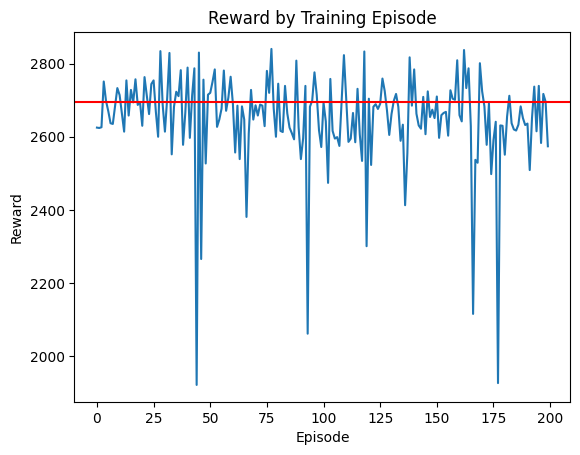

In [14]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

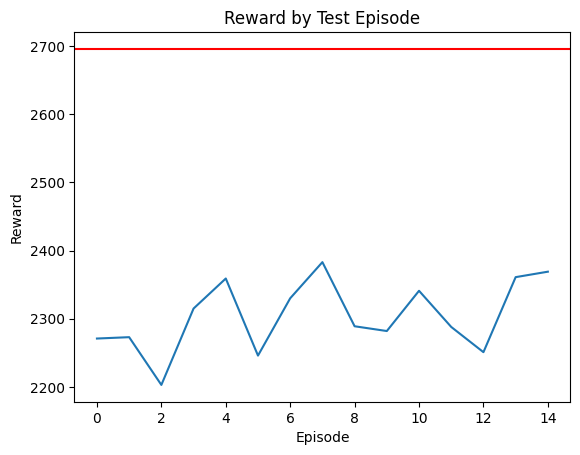

In [15]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

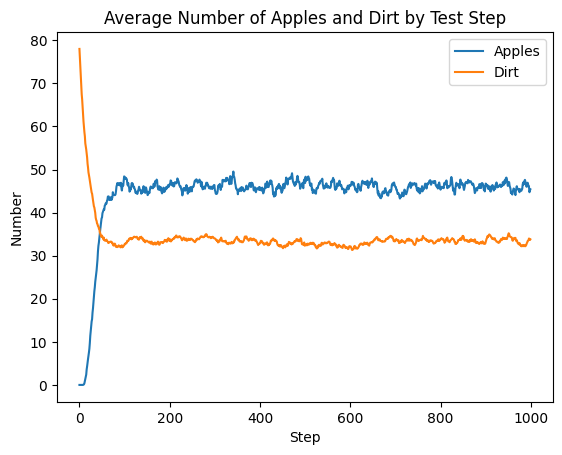

In [16]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(max_steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

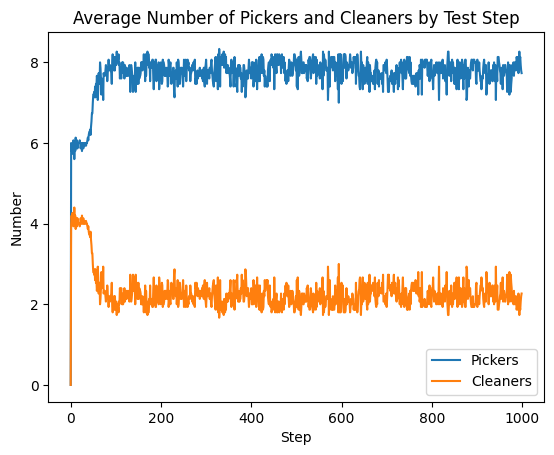

In [17]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(max_steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

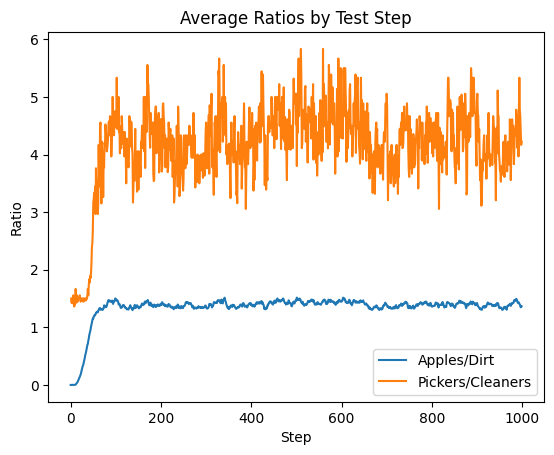

In [18]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(max_steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps, avg_apple_dirt_ratios, label="Apples/Dirt")
plt.plot(picker_cleaner_steps, avg_picker_cleaner_ratios, label="Pickers/Cleaners")
plt.legend()
plt.show()